In [92]:
# Import Dependencies

import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import requests
import json
from census import Census
from scipy.stats import linregress
import gmaps
from pprint import pprint

# Import Census and Google API keys
from config import census_key, gkey

In [ ]:
# Read in original csv file as dataframe
accidents_csv = pd.read_csv("Resources/US_Accidents_Dec21_updated.csv")

# Display first 5 rows of dataframe
accidents_csv.head()

In [ ]:
# Create new column consisting of only the year
accidents_csv["Year"] = accidents_csv["Start_Time"].str[:4]

# Create new dataframe to bypass having to load original
accidents_df = accidents_csv

# Display first 5 rows
accidents_df.head()

In [ ]:
# Clean dataframe by limiting to selected columns
accidents_cleaned_df = accidents_df[['Start_Time', 'Start_Lat', 'Start_Lng',
       'Severity', 'Distance(mi)', 'County', 'State', 'Zipcode', 'Country',
       'Sunrise_Sunset', 'Year']]

# Display first 5 rows of cleaned df
accidents_cleaned_df.head()

In [ ]:
# Create separate csv files for each year from 2016 to 2021

# List comprehension to create list of years included in datases cast as strings
years = [str(year) for year in range(2016,2022)]

# For loop to iterate through and export a separate csv file for each year
for yr in years:
    current_year = accidents_cleaned_df[accidents_cleaned_df["Year"] == yr]
    current_year.to_csv(f"Resources/accidents_{yr}.csv", index=False)

## Start from here!

In [29]:
# Designate selected year for dataframe
selected_year = "2019"

# Create Census object with Census API key from the selected year
c = Census(census_key, year=int(selected_year))

# Read in csv file for selected year as accidents_df
accidents_selected_year_df = pd.read_csv(f"Resources/accidents_{selected_year}.csv")

# Display first 5 rows of dataframe
accidents_selected_year_df.head()

,Start_Time,Start_Lat,Start_Lng,Severity,Distance(mi),County,State,Zipcode,Country,Sunrise_Sunset,Year
0,2019-10-02 12:50:00,40.736515,-74.084907,4,0.021,Hudson,NJ,07306,US,Day,2019
1,2019-11-01 16:18:00,29.955075,-90.071696,4,0.137,Orleans,LA,70112-2503,US,Day,2019
2,2019-06-04 16:00:00.000000000,29.773556,-95.351304,4,0.097,Harris,TX,77026-7228,US,Day,2019
3,2019-10-19 04:30:00.000000000,38.875540,-77.280396,4,1.483,Fairfax County,VA,22031,US,Night,2019
4,2019-12-17 09:12:52,33.634089,-112.106196,4,0.193,Maricopa,AZ,85023,US,Day,2019


In [30]:
county_count = accidents_selected_year_df.groupby(["State", "County"]).count()[["Start_Time"]]

county_count

Start_Time
State County                
AL    Autauga             10
      Baldwin             19
      Barbour              3
      Bibb                 6
      Blount              21
...                      ...
WY    Platte               5
      Sheridan             1
      Sublette             2
      Sweetwater          12
      Teton                2

[2087 rows x 1 columns]

In [31]:
# Select State, Country, and Start Lat/Lng columns as new dataframe
locations_df = accidents_selected_year_df[["State", "County", "Start_Lat", "Start_Lng"]]

# Merge dataframes to create new df consisting of the number of accidents in each county and the exact location of each
county_location_count = pd.merge(locations_df, county_count, on=["State", "County"])

In [32]:
#Rename columns
county_location_count.rename(columns={"Start_Time" : "Accident Count", 
                                        "Start_Lat" : "Lat", 
                                        "Start_Lng" : "Lng"}, inplace=True)

county_location_count.sort_values("State", inplace=True)

county_location_count.head()

,State,County,Lat,Lng,Accident Count
257813,AL,Dale,31.53060,-85.72338,6
255855,AL,Henry,31.35595,-85.17971,1
255861,AL,Fayette,33.69111,-87.82859,1
255862,AL,Geneva,31.15342,-85.64058,3
255863,AL,Geneva,31.18297,-86.14815,3


In [33]:
# Create new dataframe showing number of accidents and average coordinates by county

accidents_by_county = county_location_count.groupby(["State", "County"], as_index=False).mean()

accidents_by_county.head()

,State,County,Lat,Lng,Accident Count
0,AL,Autauga,32.549176,-86.501131,10
1,AL,Baldwin,30.687659,-87.845268,19
2,AL,Barbour,31.863403,-85.271253,3
3,AL,Bibb,33.001936,-87.117345,6
4,AL,Blount,33.943876,-86.610055,21


In [34]:
# Create dictionary for state abbreviations

states_abbreviation = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [52]:
# Run Census Search to retrieve income data by county
census_data = c.acs5.get(("NAME", "B01003_001E", "B19013_001E","B19301_001E"), {'for': 'county:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Rename columns
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19013_001E": "Median Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "County",
                                      "state": "State Code",
                                      "county": "County Code"})

# Split "County" column into separate "County" and "State" columns
census_pd[["County", "State"]] = census_pd["County"].str.split(" County, ", expand=True)

# Combine State and County codes into new column for county identification
census_pd["County FIPS"] = census_pd["State Code"] + census_pd["County Code"]

# Drop State and County code columns
census_pd.drop(columns=["State Code", "County Code"], inplace=True)

# Convert State names to state abbreviations
census_pd.replace({"State": states_abbreviation}, inplace=True)

census_pd.head()

,County,Population,Median Household Income,Per Capita Income,State,County FIPS
0,Fayette,21565.0,46650.0,23194.0,IL,17051
1,Logan,29003.0,57308.0,27546.0,IL,17107
2,Saline,23994.0,44090.0,25342.0,IL,17165
3,Lake,701473.0,89427.0,45766.0,IL,17097
4,Massac,14219.0,47481.0,23539.0,IL,17127


In [108]:
# Merge census data with accident dataframe on State/County for counties listed in accidents_by_county dataframe
accidents_census_df = pd.merge(accidents_by_county, census_pd, on=["State","County"], how="left")

# Calculate accidents per capita and add to new column
accidents_census_df["Accidents (per 1000)"] = (accidents_census_df["Accident Count"] / accidents_census_df["Population"]) * 1000

# Drop rows with missing data
accident_data_complete = accidents_census_df.dropna()

# Save dataframe as csv file
accident_data_complete.to_csv("Resources/accidents_census_bycounty.csv")

# Display first 5 rows of dataframe
accident_data_complete.head()

,State,County,Lat,Lng,Accident Count,Population,Median Household Income,Per Capita Income,County FIPS,Accidents (per 1000)
0,AL,Autauga,32.549176,-86.501131,10,55380.0,58731.0,29819.0,01001,0.180571
1,AL,Baldwin,30.687659,-87.845268,19,212830.0,58320.0,32626.0,01003,0.089273
2,AL,Barbour,31.863403,-85.271253,3,25361.0,32525.0,18473.0,01005,0.118292
3,AL,Bibb,33.001936,-87.117345,6,22493.0,47542.0,20778.0,01007,0.266750
4,AL,Blount,33.943876,-86.610055,21,57681.0,49358.0,24747.0,01009,0.364071


In [109]:
# Read in csv file as new cleaned dataframe
accident_data_complete = pd.read_csv("Resources/accidents_census_bycounty.csv")

accident_data_complete.head()

,Unnamed: 0,State,County,Lat,Lng,Accident Count,Population,Median Household Income,Per Capita Income,County FIPS,Accidents (per 1000)
0,0,AL,Autauga,32.549176,-86.501131,10,55380.0,58731.0,29819.0,1001,0.180571
1,1,AL,Baldwin,30.687659,-87.845268,19,212830.0,58320.0,32626.0,1003,0.089273
2,2,AL,Barbour,31.863403,-85.271253,3,25361.0,32525.0,18473.0,1005,0.118292
3,3,AL,Bibb,33.001935,-87.117345,6,22493.0,47542.0,20778.0,1007,0.266750
4,4,AL,Blount,33.943876,-86.610055,21,57681.0,49358.0,24747.0,1009,0.364071


In [ ]:
# Configure map plot
marker_size = accidents_census_by_county["Accidents (per 1000)"] * 1000

# accident_county_map = accidents_census_df.hvplot.points(
#     "Lng",
#     "Lat",
#     geo = True,
#     tiles = "OSM",
#     frame_width = 800,
#     frame_height = 600,
#     scale = 1,
#     xlabel = "Longitude",
#     ylabel = "Latitude",
#     title = f"Accidents by County in {selected_year}",
#     alpha=0.5,
#     size = marker_size,
#     color = "purple",
#     hover_cols = ["County", "Accident Count", "Accidents (per 1000)"]
#     )


accident_county_map = accidents_census_by_county.hvplot.heatmap(
    x = "Lng",
    y = "Lat",
    cmap="seismic",
    width = 800,
    height = 600

    )
    
# Display the map
display(accident_county_map)

In [110]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

# Store 'Lat' and 'Lng' into  locations 
locations = accident_data_complete[["Lat", "Lng"]]

median_income = accident_data_complete["Median Household Income"]
accidents_per_1000 = accident_data_complete["Accidents (per 1000)"]

accident_data_complete.head()

,Unnamed: 0,State,County,Lat,Lng,Accident Count,Population,Median Household Income,Per Capita Income,County FIPS,Accidents (per 1000)
0,0,AL,Autauga,32.549176,-86.501131,10,55380.0,58731.0,29819.0,1001,0.180571
1,1,AL,Baldwin,30.687659,-87.845268,19,212830.0,58320.0,32626.0,1003,0.089273
2,2,AL,Barbour,31.863403,-85.271253,3,25361.0,32525.0,18473.0,1005,0.118292
3,3,AL,Bibb,33.001935,-87.117345,6,22493.0,47542.0,20778.0,1007,0.266750
4,4,AL,Blount,33.943876,-86.610055,21,57681.0,49358.0,24747.0,1009,0.364071


In [106]:
# Create an Accidents Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=accidents_per_1000, 
                                 dissipating=False, max_intensity=20,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

The r-value is: -0.004938967786531987


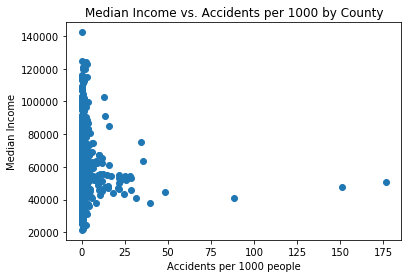

In [113]:
x_values = accidents_per_1000
y_values = median_income

plt.scatter(x_values, y_values)
plt.title("Median Income vs. Accidents per 1000 by County")
plt.xlabel("Accidents per 1000 people")
plt.ylabel("Median Income")

(slope, intercept, rvalue, pvalue, stderr) = linregress(accidents_per_1000, median_income)

# Define the line equation as a string in slope-intercept form
line_eq = f"y={round(slope,2)}x + {round(intercept,2)}"

# Calculate y-values of regression line from the x_values parameter, slope and y-intercept
regress_values = slope * x_values + intercept

# Print the r-value (correlation coefficient)
print(f"The r-value is: {rvalue}")